# Multi-label classifier

Обучите модель для предсказания аттрибутов по фотографии на датасете [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

**Задача**
Датасет содержит фотографий лиц. Каждая фотография характреризуется набором признаков: пол, возраст, улыбка ... всего 40 признаков

Нужно обучить модель которая будет предсказывать признаки по фотографии.
И оценить качество ее работы используя соответствующие метрики.



# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.

## Анализ данных (EDA)

# Загрузка данных

In [ ]:
!wget -O celeba.zip https://www.kaggle.com/api/v1/datasets/download/jessicali9530/celeba-dataset
!unzip celeba.zip -d celeba

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from sklearn.metrics import f1_score,precision_score, precision_recall_fscore_support
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
from IPython.display import clear_output
from torchvision.models import resnet18, ResNet18_Weights
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image_path='../content/celeba/img_align_celeba/img_align_celeba'
df_attr=pd.read_csv('../content/celeba/list_attr_celeba.csv')
df_landmarks=pd.read_csv('../content/celeba/list_landmarks_align_celeba.csv')
df_bbox=pd.read_csv('../content/celeba/list_bbox_celeba.csv')

df_attr.replace(-1,0,inplace=True)
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
df_landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


# Анализ

In [ ]:
attr_names = df_attr.columns[1:]
print("Attributes: ",", ".join(attr_names))
print(len(attr_names))

Attributes:  5_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young
40


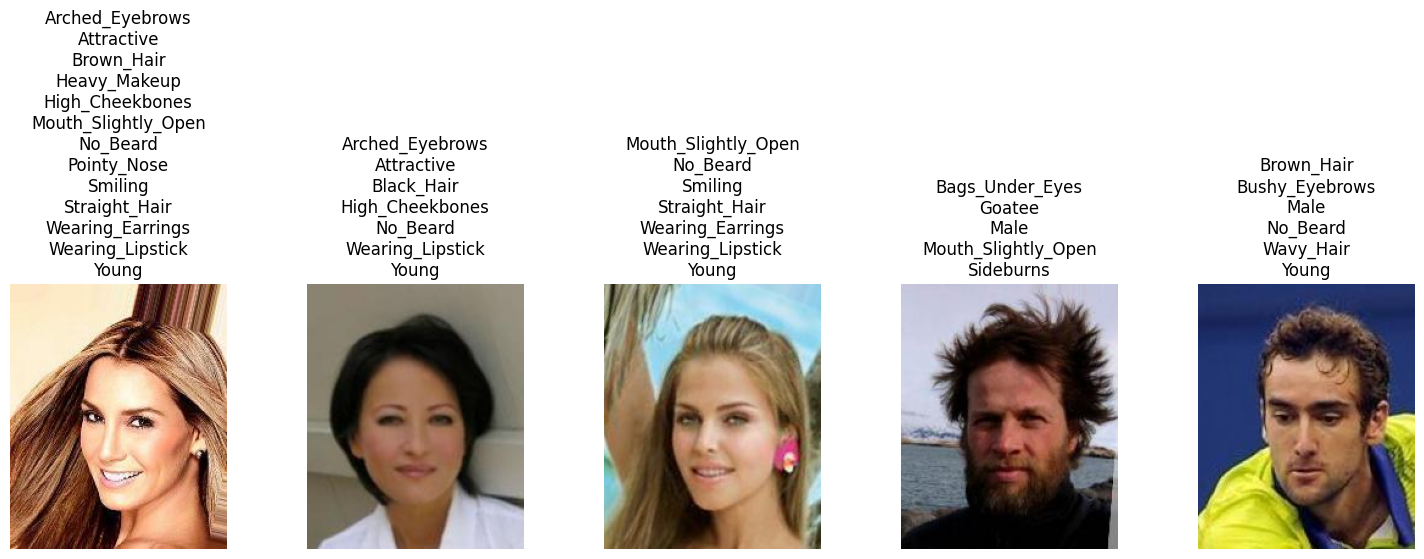

In [ ]:
def show_images(df, indices, image_column='image_id', attribute_columns=None):
    if attribute_columns is None:
        attribute_columns = [col for col in df.columns if col != image_column]

    # количество изображений
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, idx in enumerate(indices):
        image_path_curr = df.iloc[idx][image_column]
        attributes = df.iloc[idx][attribute_columns]

        positive_attributes = attributes[attributes == 1]

        # оотбражаем изображение
        img = Image.open(image_path + "/" + image_path_curr)
        axes[i].imshow(img)
        axes[i].axis('off')

        # берём заголовки(признаки)
        attributes_str = "\n".join(f"{col}" for col in positive_attributes.index)
        if attributes_str == "":
            attributes_str = "No attributes = 1"

        axes[i].set_title(f"{attributes_str}", fontsize=12)

    plt.tight_layout()
    plt.show()


show_images(df_attr, [0,100,1000,10000,100000])

# EDA

In [ ]:
#общая информация о датасете
attr_names = df_attr.columns[1:]
print("Attributes: ","\n".join(attr_names))
print(f"\nВсего аттрибутов: {len(attr_names)}")

Attributes:  5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young

Всего аттрибутов: 40


In [ ]:
attr_df = df_attr.drop(columns=['image_id'])

# выводим инфромацию о данных
print(attr_df.info())
print(attr_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   5_o_Clock_Shadow     202599 non-null  int64
 1   Arched_Eyebrows      202599 non-null  int64
 2   Attractive           202599 non-null  int64
 3   Bags_Under_Eyes      202599 non-null  int64
 4   Bald                 202599 non-null  int64
 5   Bangs                202599 non-null  int64
 6   Big_Lips             202599 non-null  int64
 7   Big_Nose             202599 non-null  int64
 8   Black_Hair           202599 non-null  int64
 9   Blond_Hair           202599 non-null  int64
 10  Blurry               202599 non-null  int64
 11  Brown_Hair           202599 non-null  int64
 12  Bushy_Eyebrows       202599 non-null  int64
 13  Chubby               202599 non-null  int64
 14  Double_Chin          202599 non-null  int64
 15  Eyeglasses           202599 non-null  int64
 16  Go

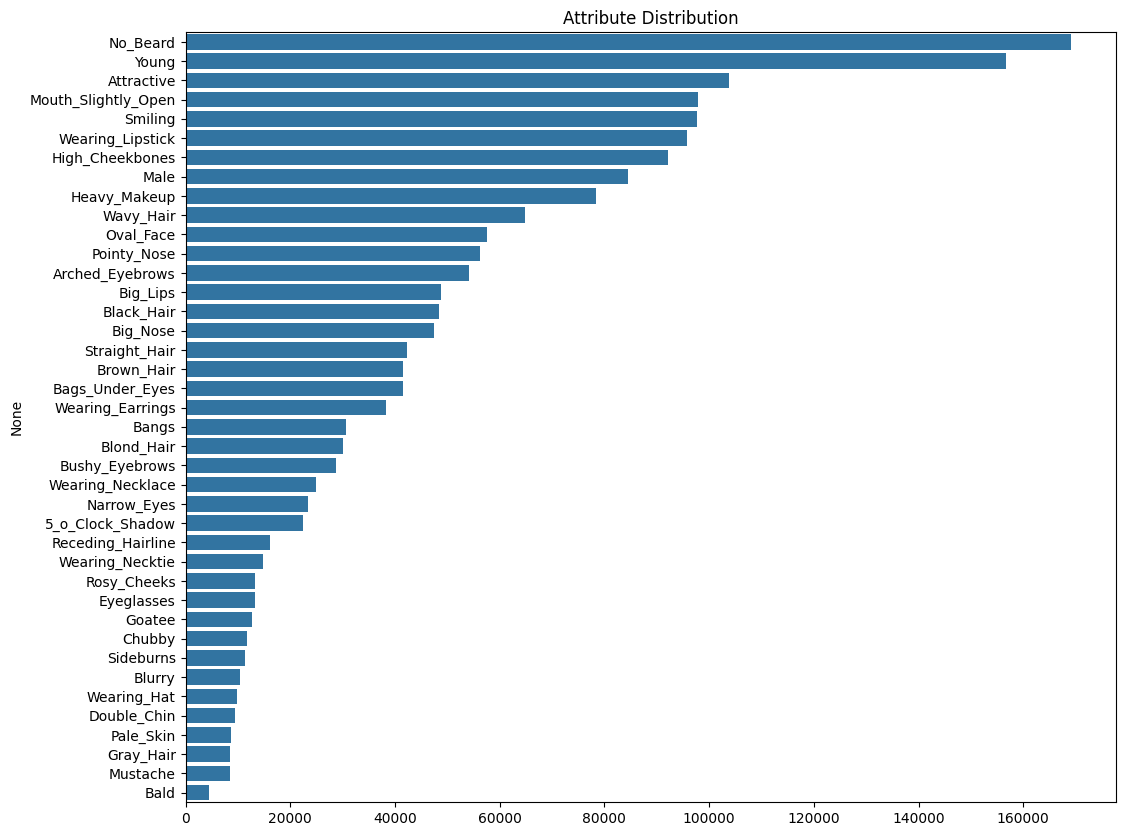

In [ ]:
# посчитаем количество примеров для каждого атрибута
attr_distribution = attr_df.sum().sort_values(ascending=False)

# топ-40 атрибутов
plt.figure(figsize=(12,10))
sns.barplot(x=attr_distribution.values, y=attr_distribution.index)
plt.title('Attribute Distribution')
plt.show()

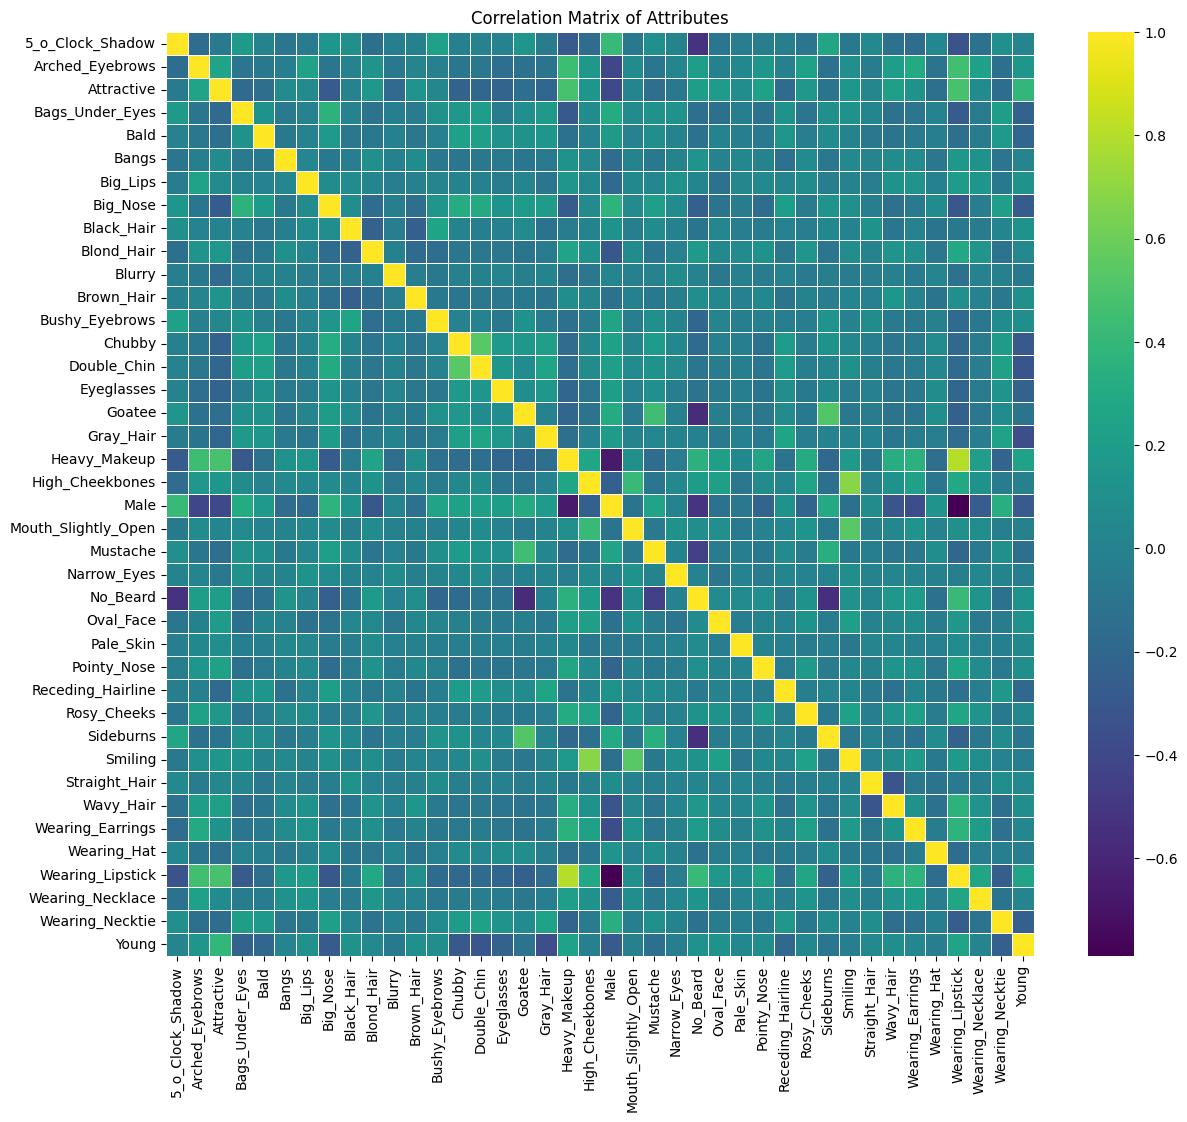

In [ ]:
# построим корреляционную матрицу
corr_matrix = attr_df.corr()

# выведем наглядно корреляцию
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix of Attributes')
plt.show()

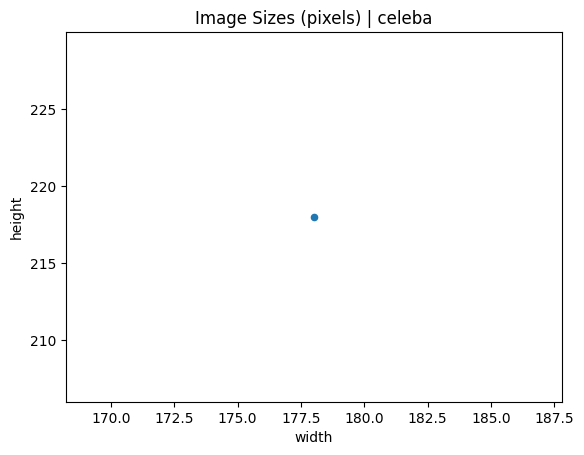

In [ ]:
# получение размеров изображения
def get_dims(img):
    _, h, w = img.shape
    return h, w

transform = transforms.Compose([
    transforms.ToTensor()  # в тензор
])

# папка с изображениям
directories = {
    'celeba': '/content/celeba/img_align_celeba/img_align_celeba'
}

for n, d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath) if f.endswith('.jpg')]

    dims = []
    for file in filelist:
        img = datasets.folder.default_loader(file)
        img_tensor = transform(img)
        dims.append(get_dims(img_tensor))  # получаем размеры

    # создаем df для размеров
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])

    # группируем по размеру и считаем количество
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0: 'count'})

    # итог
    sizes.plot.scatter(x='width', y='height')
    plt.title(f'Image Sizes (pixels) | {n}')
    plt.show()

## Выводы
После некоторого анализа данных у меня получилось выделить две возможные проблемы:
1. Плохо сбалансированные класса: некоторые атрибуты имеют сильный дисбаланс, что может потребовать дополнительной обработки.
2. Корреляция атрибутов: высокая корреляция между атрибутами может ухудшить результат модели, так как модель может переобучаться на схожие признаки. (Например: связь Heavy_makeup и Wearing_lipstick)


# Подготовка данных

In [ ]:
class MultiLabelDataset():
    def __init__(self):
        # инициализация атрибутов для хранения
        self.x_train, self.x_val, self.x_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None
        self.mode = 'train'  #режим по умолчанию
        self.labels, self.images = [], []

        for i, row in df_attr.iterrows():
            self.labels.append(list(row.iloc[1:]))

        self.labels = np.array(self.labels)  # преобразуем список в массив np

        # получение имен изображений из DataFrame
        img_names = df_attr['image_id'].to_list()
        for img_name in tqdm(img_names):
            img = Image.open(os.path.join(image_path, img_name))  # ьерём изображение
            img = np.array(img)  # изображение -> в массив np
            img = cv2.resize(img, (64, 64))
            img = img.reshape(3, 64, 64)  # переставляем для соответствия формату
            self.images.append(img)

        self.images = np.array(self.images)

    def train_val_test_split(self):
        # разделяем данные
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.images, self.labels, test_size=0.33, random_state=52
        )
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
            self.x_train, self.y_train, test_size=0.33, random_state=52
        )

    def __len__(self):
        # возвращает длину в зависимости от текущего режима
        if self.mode == 'train':
            return self.x_train.shape[0]
        elif self.mode == 'val':
            return self.x_val.shape[0]
        elif self.mode == 'test':
            return self.x_test.shape[0]
        else:
            return self.images.shape[0]

    def __getitem__(self, idx):
        # получение данных по индексу в зависимости от режима
        if self.mode == 'train':
            sample = {'image': self.x_train[idx], 'label': self.y_train[idx]}
        elif self.mode == 'val':
            sample = {'image': self.x_val[idx], 'label': self.y_val[idx]}
        elif self.mode == 'test':
            sample = {'image': self.x_test[idx], 'label': self.y_test[idx]}
        else:
            sample = {'image': self.images[idx], 'label': self.labels[idx]}

        return sample


In [ ]:
# создаём экземпляр для датасеты
d = MultiLabelDataset()

100%|██████████| 202599/202599 [01:52<00:00, 1798.11it/s]


In [ ]:
# разбиваем на части( тест, валидация и тренировака)
d.train_val_test_split()

In [ ]:
dataloader = DataLoader(d, batch_size=64, shuffle=True, drop_last=True)

# Метрики

В случае с multilabel classification не совсем подойдут базовые для многоклассовой классификации способы определение точности. Здесь, например, при реальных тегах [1, 5, 15], а предсказанных [4, 5, 15] - прогноз не является ни полностью правильным, ни полностью ошибочным, т.е. нам надо понимать, что прогноз, содержащий подмножество реальных классов, следует считать лучшим, чем прогноз, который не содержит ни одного из них. Для этого используем показатель Хэмминга.

Показатель Хэмминга рассчитывает отношение количества правильно предсказанных меток к общему количеству меток, не принимая во внимание различия между прогнозом и фактической правдой для каждой выборки данных.

In [ ]:
def hamming_score(y_true, y_pred):
    num_samples = len(y_true)
    total_correct = 0

    for true_labels, pred_labels in zip(y_true, y_pred):
        correct_labels = (true_labels == pred_labels).sum()
        total_correct += correct_labels

    hamming_score = total_correct / (num_samples * len(y_true[0]))

    return hamming_score

## Baseline

В качестве начальной я взял модель из прошлого ДЗ, но чуть-чуть её изменил: добавил пулинги и свёрточные слои.

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.vgg = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # сверточный слой
            nn.ReLU(),  # активация
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Еще один сверточный слой
            nn.LeakyReLU(),  # активация
            nn.MaxPool2d(kernel_size=2, stride=2),  # пуллинг
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # пуллинг
        )

        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.vgg(x)

        x = nn.Flatten()(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))

        x = self.fc3(x)

        return x


In [ ]:
model = BaseModel(num_classes=40)

## Решение

In [ ]:
def get_multilabel_evaluation(model_eval, test_loader):
    all_predictions = []
    all_targets = []

    #режим оценки
    model_eval.eval()

    # отключение вычисления градиентов
    with torch.no_grad():
        for D in tqdm(test_loader, desc=f'Testing'):
            # извлечение входных изображений и меток
            inputs = D['image'].to(device, dtype=torch.float)
            targets = D['label'].to(device, dtype=torch.float)

            # получение предсказаний
            outputs = model_eval(inputs)
            # применение порога
            predictions = (outputs > 0.5).float()

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    return all_predictions, all_targets


In [ ]:
def train_model(train_model):
  # установка начальной скорости обучения и количества эпох
  l_rate = 0.001
  num_epochs = 5

  # инициализация оптимизатора и функции потерь
  optimizer = optim.Adam(train_model.parameters(), lr=l_rate)
  criterion = nn.BCEWithLogitsLoss()

  epoch_train_loss = []
  epoch_val_loss = []
  val_hamming_scores = []
  train_hamming_scores = []

  # перенос на устройствоы
  train_model = train_model.to(device)

  # цикл по эпохам
  for epoch in range(num_epochs):
    val_losses = []
    train_losses = []

    # режим тренировки
    train_model.train()
    d.mode = 'train'

    for D in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}, Training'):
      # зануление градиентов
      optimizer.zero_grad()

      # извлечение и отправка на устройство
      data = D['image'].to(device, dtype=torch.float)
      labels = D['label'].to(device, dtype=torch.float)

      # получение прдесказания
      y_hat = train_model(data)

      loss = torch.sum(criterion(y_hat, labels)) # получение потерь
      loss.backward()
      optimizer.step()  # обновление параметров

      predicted_labels = (y_hat > 0.5).float()
      hamming_score_value = hamming_score(labels.cpu().numpy(), predicted_labels.cpu().numpy()) # получение точности тренировочной

      train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))
    train_hamming_scores.append(hamming_score_value)

    val_losses = []
    d.mode = 'val'
    train_model.eval()

    with torch.no_grad():
      for D in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}, Validating'):
        # извлечение и отправка на устройство
        data = D['image'].to(device, dtype=torch.float)
        labels = D['label'].to(device, dtype=torch.float)

        # получение прдесказания
        y_hat = train_model(data)

        loss = torch.sum(criterion(y_hat, labels))
        predicted_labels = (y_hat > 0.5).float()

        # получение точности валидационной
        val_hamming_score = hamming_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())

        # сохранение потерь для текущей итерации
        val_losses.append(loss.item())

    val_hamming_scores.append(val_hamming_score)
    epoch_val_loss.append(np.mean(val_losses))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.5f}, Val Loss: {np.mean(val_losses):.5f}, Train Hamming Score: {hamming_score_value:.4f}, Val Hamming Score: {val_hamming_score:.4f}\n')



In [ ]:
train_model(model)

Epoch 1/5, Validating: 100%|██████████| 699/699 [00:14<00:00, 47.90it/s]


Epoch 1/5, Train Loss: 0.37915, Val Loss: 0.31114, Train Hamming Score: 0.8680, Val Hamming Score: 0.8539



Epoch 2/5, Validating: 100%|██████████| 699/699 [00:14<00:00, 49.10it/s]


Epoch 2/5, Train Loss: 0.30176, Val Loss: 0.29500, Train Hamming Score: 0.8723, Val Hamming Score: 0.8656



Epoch 3/5, Validating: 100%|██████████| 699/699 [00:14<00:00, 49.44it/s]


Epoch 3/5, Train Loss: 0.28949, Val Loss: 0.29083, Train Hamming Score: 0.8727, Val Hamming Score: 0.8812



Epoch 4/5, Validating: 100%|██████████| 699/699 [00:14<00:00, 48.80it/s]


Epoch 4/5, Train Loss: 0.28213, Val Loss: 0.28958, Train Hamming Score: 0.8762, Val Hamming Score: 0.8820



Epoch 5/5, Validating: 100%|██████████| 699/699 [00:14<00:00, 49.62it/s]

Epoch 5/5, Train Loss: 0.27550, Val Loss: 0.28319, Train Hamming Score: 0.8715, Val Hamming Score: 0.8559



In [ ]:
def show_results(res_model):

  d.mode = 'test' # установка режима

  true, pred = get_multilabel_evaluation(res_model, dataloader) # тестирование

  predictions_np = np.concatenate(pred)
  targets_np = np.concatenate(true)

  clear_output()

  # подсчёт метрик тестирования
  precision, recall, f_score, _ = precision_recall_fscore_support(targets_np, predictions_np, average='weighted')

  print(f"precision: {precision}, recall: {recall}, f_score: {f_score}")

  # подсчёт метрик тестирования
  score = hamming_score(targets_np, predictions_np)

  print(f'Hamming Score: {score}')

In [ ]:
show_results(model)

precision: 0.7225640395331033, recall: 0.8585814808633434, f_score: 0.7697686592596369
Hamming Score: 0.8736489014607279


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Попробую улучшить показатель, а для этого возьму модель resnet18

In [ ]:
class ResModel(nn.Module):
    def __init__(self, num_classes):
        super(ResModel, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.in_features, num_classes) # свой последний линейный слой для получение ответов

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
up_model = ResModel(40)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [ ]:
train_model(up_model)

Epoch 1/5, Validating: 100%|██████████| 699/699 [00:18<00:00, 38.63it/s]


Epoch 1/5, Train Loss: 0.30373, Val Loss: 0.27986, Train Hamming Score: 0.8867, Val Hamming Score: 0.8773



Epoch 2/5, Validating: 100%|██████████| 699/699 [00:18<00:00, 37.15it/s]


Epoch 2/5, Train Loss: 0.26530, Val Loss: 0.26403, Train Hamming Score: 0.8832, Val Hamming Score: 0.8742



Epoch 3/5, Validating: 100%|██████████| 699/699 [00:18<00:00, 37.57it/s]


Epoch 3/5, Train Loss: 0.25113, Val Loss: 0.25370, Train Hamming Score: 0.8832, Val Hamming Score: 0.8906



Epoch 4/5, Validating: 100%|██████████| 699/699 [00:19<00:00, 35.11it/s]


Epoch 4/5, Train Loss: 0.24041, Val Loss: 0.25972, Train Hamming Score: 0.8902, Val Hamming Score: 0.8867



Epoch 5/5, Validating: 100%|██████████| 699/699 [00:18<00:00, 37.08it/s]

Epoch 5/5, Train Loss: 0.23049, Val Loss: 0.24935, Train Hamming Score: 0.8996, Val Hamming Score: 0.8969



## Оценка результата

выведем реузльтаты второй модели

In [ ]:
show_results(up_model)

precision: 0.741663498819358, recall: 0.8581916765396564, f_score: 0.7820116839505266
Hamming Score: 0.887755926724138


Как можно заметить по полученным результатом resnet18 со стандартными весами смог улучшить результат, но на достаточно незначительное число (примерно на 1%).
Если первая модель угадывала верные метки в примерно 88% случаев, то улучшенная модель уже около 89%. Данные результаты считаю достаточно хорошими, но, очевидно, что их ещё можно улучшить.